# This is a notebook for SVM (with Stemming and Wor2Vec), training a model to be able to categorize fake vs real news

In [1]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'gensim'

Make a function to apply text preprocesing to the datasets. </br>
Load the data formating it correctly for easy use and apply the preporcessing </br>
Split the data into a label and title columns so es easy to access only the title for training

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra white space
    text = text.strip()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"/content/training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"/content/testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [ ]:
# Apply preprocessing to the 'title' column
train_data['title'] = train_data['title'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)

print(train_data['title'].head())
print(test_data['title'].head())

0    donald trump sends embarrassing new years eve ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas speech
Name: title, dtype: object
0    copycat muslim terrorist arrested assault weapons
1    wow chicago protester caught camera admits vio...
2          germanys fdp look fill schaeubles big shoes
3    mi school sends welcome back packet warning ki...
4    un seeks massive aid boost amid rohingya emerg...
Name: title, dtype: object


Tokenice and stemming to prepare the titles to convert to numbers using TF_IDF

In [ ]:
# Tokenize train and testing data
def tokenizeDataframe(text):
    tokens = word_tokenize(text)
    return tokens

train_data['title'] = train_data['title'].apply(tokenizeDataframe)
test_data['title'] = test_data['title'].apply(tokenizeDataframe)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  [donald, trump, sends, embarrassing, new, year...
1      0  [drunk, bragging, trump, staffer, started, rus...
2      0  [sheriff, david, clarke, becomes, internet, jo...
3      0  [trump, obsessed, even, obamas, name, coded, w...
4      0  [pope, francis, called, donald, trump, christm...
  label                                              title
0     2  [copycat, muslim, terrorist, arrested, assault...
1     2  [wow, chicago, protester, caught, camera, admi...
2     2  [germanys, fdp, look, fill, schaeubles, big, s...
3     2  [mi, school, sends, welcome, back, packet, war...
4     2  [un, seeks, massive, aid, boost, amid, rohingy...


In [ ]:
# stemming for simplifying the words
stemmer = PorterStemmer()
train_data['title'] = train_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])
test_data['title'] = test_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])

print("Stemmed Tokens:", train_data['title'].head())
print("Stemmed Tokens:", test_data['title'].head())

Stemmed Tokens: 0    [donald, trump, send, embarrass, new, year, ev...
1    [drunk, brag, trump, staffer, start, russian, ...
2    [sheriff, david, clark, becom, internet, joke,...
3    [trump, obsess, even, obama, name, code, websi...
4    [pope, franci, call, donald, trump, christma, ...
Name: title, dtype: object
Stemmed Tokens: 0    [copycat, muslim, terrorist, arrest, assault, ...
1    [wow, chicago, protest, caught, camera, admit,...
2      [germani, fdp, look, fill, schaeubl, big, shoe]
3    [mi, school, send, welcom, back, packet, warn,...
4    [un, seek, massiv, aid, boost, amid, rohingya,...
Name: title, dtype: object


Apply TF-IDF to the dataset to conver the words into numerical values for model training

In [ ]:
# First, make sure we have the tokenized data ready
tokenized_titles = train_data['title'].tolist()  # These should be lists of tokens

# Train a Word2Vec model
embedding_dim = 100  # You can adjust this dimension
w2v_model = Word2Vec(tokenized_titles, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [ ]:
def get_document_vector(tokens, model, embedding_dim):
    vec = np.zeros(embedding_dim)
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            # Skip words not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

# Convert documents to vectors
X_train_vectors = np.array([get_document_vector(tokens, w2v_model, embedding_dim) for tokens in train_data['title']])
X_test_vectors = np.array([get_document_vector(tokens, w2v_model, embedding_dim) for tokens in test_data['title']])

# Now use these vectors for training instead of TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_train_vectors, train_data['label'], test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')  # You can choose other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

# Calculate R²
r2 = r2_score(y_test, y_pred_svm)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print(f"R²: {r2}")

Accuracy: 0.82389108476065
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      3529
           1       0.85      0.78      0.81      3302

    accuracy                           0.82      6831
   macro avg       0.83      0.82      0.82      6831
weighted avg       0.83      0.82      0.82      6831

R²: 0.2947855778005517


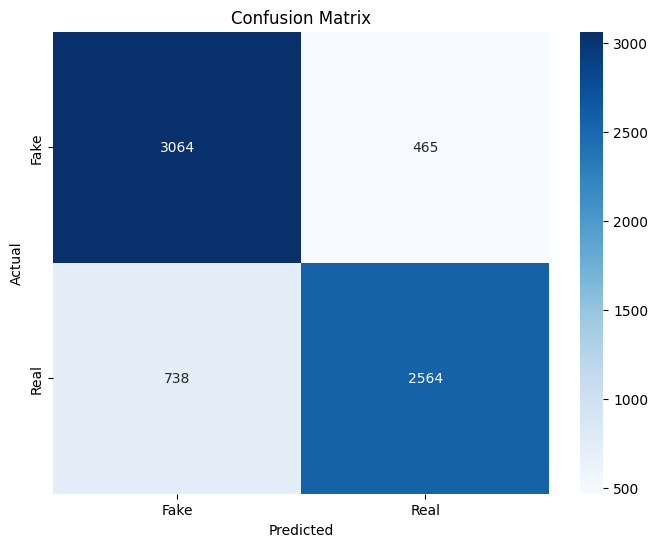

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_test_unlabeled = test_data['title'].tolist()

# Predict labels for the unlabeled data
predicted_labels = svm_model.predict(X_test_unlabeled)

test_data['label'] = predicted_labels

# Display the first few rows of the updated testing data
print(test_data.head())

In [ ]:
# Make sure title is string, not list
test_data['title'] = test_data['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Export respecting original format
test_data[['label', 'title']].to_csv(
    r'word2Vec_test_data.csv',
    sep='\t',  # TAB separator
    index=False,
    header=False  # No column names
)
print("\n:white_check_mark: Predictions exported successfully in correct format!")
